In [1]:
from scripts import pricing_ai
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
pd.set_option('display.max_rows',200)

#### **データ：価格の変動を持ったstockidデータ**

In [2]:
%%time
df = pricing_ai.get_data('sql/stock_cars.sql')

CPU times: user 1min 25s, sys: 42.8 s, total: 2min 7s
Wall time: 13min 30s


#### **前処理：値段未設定を削除**

In [3]:
pricing_ai.print_shape(df)
df = df[df.price != 999999999]
pricing_ai.print_shape(df)

(59161303, 3)
(58740983, 3)


#### **データ：初回と成約**

In [4]:
first_pub = pricing_ai.get_preprocessing_data(sql_path='sql/first_pub.sql',col='min_date')
contract = pricing_ai.get_preprocessing_data(sql_path='sql/contract.sql',col='delete_date')

#### **データ：初回の日付と成約の日付作成**

In [5]:
start_day_dict = first_pub.set_index('stock_id')['min_date'].to_dict()
end_day_dict = contract.set_index('stock_id')['delete_date'].to_dict()

#### **前処理：初回と成約の日付を結合**

In [6]:
df['end_day']=df.stock_id.map(end_day_dict)
df['start_day']=df.stock_id.map(start_day_dict)

In [7]:
del start_day_dict, end_day_dict, first_pub, contract

In [8]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by=['stock_id', 'date'])

df['min_price'] = df.groupby('stock_id')['price'].transform('min')
df['max_price'] = df.groupby('stock_id')['price'].transform('max')

df['diff_price'] = df['max_price'] - df['min_price']


KeyboardInterrupt



In [ ]:
pricing_ai.print_shape(df)
df = df.dropna(subset=['start_day'])
pricing_ai.print_shape(df)

#### 前処理：価格の下落があったもの

In [8]:
df['diff_per_stockid'] = df.groupby('stock_id').price.diff().fillna(0)

In [11]:
pricing_ai.print_shape(df)
df = df[df.diff_price != 0]
pricing_ai.print_shape(df)

,date,stock_id,price,end_day,start_day,diff_per_stockid
0,2021-07-15,0205200A30210529W001,1498000,2021-09-16,2021-05-29,0
1,2021-10-25,0570625A30210804W001,2230000,2021-12-03,2021-08-04,0
2,2021-02-14,0803431A30201223W001,1630000,2021-11-19,2020-12-23,0
3,2020-03-27,0203664A30200201W001,2299000,2020-05-19,2020-02-01,0
4,2021-02-15,0505524A20201215S001,1350000,2021-09-24,2020-12-26,0
...,...,...,...,...,...,...
58861799,2020-12-17,0403977A30201105W001,150000,2021-06-02,2020-11-05,0
58861801,2020-06-09,0803400A30200529W001,150000,2020-07-16,2020-05-29,0
58861803,2020-02-15,0404091A30200108W003,150000,2020-02-16,2020-01-08,0
58861805,2020-10-01,0208051A30200719W001,150000,2020-11-07,2020-07-24,0


In [11]:
# df = df[df.diff_price.ne(0)]
# df.loc[:, 'price_diff'] = df.price.diff()

In [30]:
price_diff_df = df.groupby(['stock_id', 'price_diff']).size().to_frame('count').reset_index()

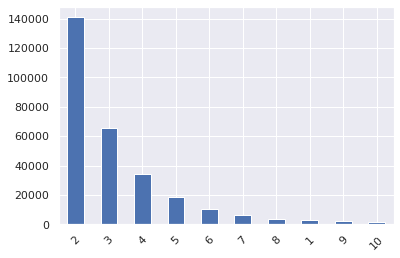

In [61]:
price_diff_df[price_diff_df.price_diff.ne(0)].groupby('stock_id')['count']\
                                            .sum()\
                                            .value_counts().head(10).plot.bar()
plt.xticks(rotation=45)
plt.show()

In [67]:
df.drop_duplicates('stock_id').max_price.mean().astype(int), df.drop_duplicates('stock_id').max_price.median().astype(int)

(1566522, 1098000)

#### 可視化：初回掲載から成約までで価格の下落があったもの

<AxesSubplot:ylabel='Frequency'>

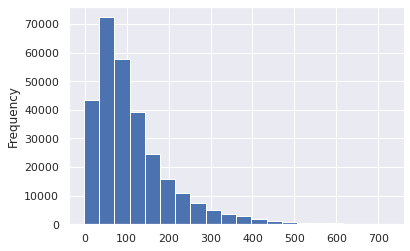

In [13]:
df_copy = df_copy[df_copy.diff_price != 0].drop_duplicates(subset=['stock_id'])
df_copy['keisai_day'] = df_copy['end_day']-df_copy['start_day']
df_copy['keisai_day'] = df_copy.keisai_day.astype('timedelta64[D]').astype(int)
df_copy['keisai_day'].plot.hist(bins=20)

In [14]:
df_copy.keisai_day.median(), df_copy.keisai_day.mean()

(87.0, 114.11965797195619)